# Movie Recommendation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import os
dataset = pd.read_csv("ml-100k/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))


In [3]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

In [5]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [6]:
dataset.head()

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [8]:
train.head()

,user_id,item_id,rating,timestamp
48131,279,1050,4,891700904
14776,245,1221,3,884923372
48545,300,502,3,882078228
6274,89,312,5,891382163
60320,850,741,5,874767519


In [9]:
test.head()

,user_id,item_id,rating,timestamp
58130,617,68,4,891308176
46637,501,299,2,883701980
44352,254,324,1,883215723
66718,795,401,5,893047320
91761,893,123,5,881625708


# Method 1 - Using Matrix Factorization

In [10]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.utils.vis_utils import model_to_dot
from keras.models import Model

n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

Using TensorFlow backend.


In [11]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

#prod = keras.layers.Concatenate([movie_vec, user_vec], name='DotProduct')
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

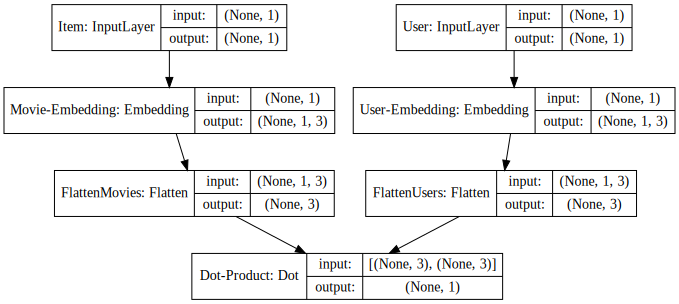

In [12]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [14]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=1)


Epoch 1/100
80000/80000 [==============================] - 2s 22us/step - loss: 12.0543
Epoch 2/100
80000/80000 [==============================] - 2s 19us/step - loss: 4.5621
Epoch 3/100
80000/80000 [==============================] - 2s 19us/step - loss: 1.9367
Epoch 4/100
80000/80000 [==============================] - 2s 19us/step - loss: 1.3153
Epoch 5/100
80000/80000 [==============================] - 2s 23us/step - loss: 1.0849
Epoch 6/100
80000/80000 [==============================] - 2s 21us/step - loss: 0.9859
Epoch 7/100
80000/80000 [==============================] - 2s 19us/step - loss: 0.9382
Epoch 8/100
80000/80000 [==============================] - 1s 19us/step - loss: 0.9130
Epoch 9/100
80000/80000 [==============================] - 2s 19us/step - loss: 0.8988
Epoch 10/100
80000/80000 [==============================] - 2s 19us/step - loss: 0.8895
Epoch 11/100
80000/80000 [==============================] - 2s 19us/step - loss: 0.8832
Epoch 12/100
80000/80000 [==============

80000/80000 [==============================] - 2s 20us/step - loss: 0.7292
Epoch 95/100
80000/80000 [==============================] - 2s 26us/step - loss: 0.7291
Epoch 96/100
80000/80000 [==============================] - 2s 20us/step - loss: 0.7286
Epoch 97/100
80000/80000 [==============================] - 2s 20us/step - loss: 0.7286
Epoch 98/100
80000/80000 [==============================] - 2s 23us/step - loss: 0.7280
Epoch 99/100
80000/80000 [==============================] - 2s 21us/step - loss: 0.7279
Epoch 100/100
80000/80000 [==============================] - 2s 25us/step - loss: 0.7276


Text(0,0.5,'Train Error')

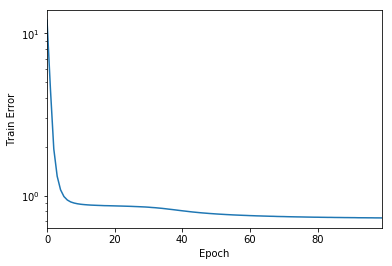

In [15]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [16]:
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating

In [17]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.69745

In [18]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,-0.867823,0.886141,0.966502
std,0.444960,0.577002,0.424479
min,-2.725756,-1.273868,-0.600796
25%,-1.177446,0.448487,0.690721
50%,-0.872903,0.917916,0.985315
75%,-0.555577,1.337371,1.260590
max,0.814672,2.470918,2.374306


In [19]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,944.000000,944.000000,944.000000
mean,-1.125625,1.172536,1.114955
std,0.483090,0.525863,0.471136
min,-2.770469,-1.385064,-0.490204
25%,-1.443670,0.880152,0.804873
50%,-1.134204,1.232678,1.110630
75%,-0.824453,1.544935,1.419213
max,1.021727,2.536964,2.740551


# Method 2 - Using Matrix Factorization (with Non Negative Constraint)

In [20]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [21]:
history_nonneg = model.fit([train.user_id, train.item_id], train.rating, epochs=10, verbose=1)

Epoch 1/10
80000/80000 [==============================] - 2s 25us/step - loss: 10.8467
Epoch 2/10
80000/80000 [==============================] - 2s 25us/step - loss: 3.7745
Epoch 3/10
80000/80000 [==============================] - 2s 24us/step - loss: 1.7703
Epoch 4/10
80000/80000 [==============================] - 2s 20us/step - loss: 1.2545
Epoch 5/10
80000/80000 [==============================] - 2s 21us/step - loss: 1.0587
Epoch 6/10
80000/80000 [==============================] - 2s 22us/step - loss: 0.9728
Epoch 7/10
80000/80000 [==============================] - 2s 21us/step - loss: 0.9312
Epoch 8/10
80000/80000 [==============================] - 2s 26us/step - loss: 0.9091
Epoch 9/10
80000/80000 [==============================] - 2s 25us/step - loss: 0.8963
Epoch 10/10
80000/80000 [==============================] - 2s 23us/step - loss: 0.8878


In [22]:
movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,0.837674,0.838462,0.837959
std,0.302317,0.303159,0.302792
min,-0.000000,-0.000000,-0.000000
25%,0.654994,0.654208,0.653290
50%,0.895354,0.894866,0.897457
75%,1.071017,1.072652,1.072992
max,1.379209,1.383501,1.407562


# Method 3 - Using Keras Deep Learning Network

In [23]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


#concat = keras.layers.Concatenate([movie_vec, user_vec], mode='concat',name='Concat')

concat = Concatenate(name="Concat", axis=1)([movie_vec, user_vec])
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

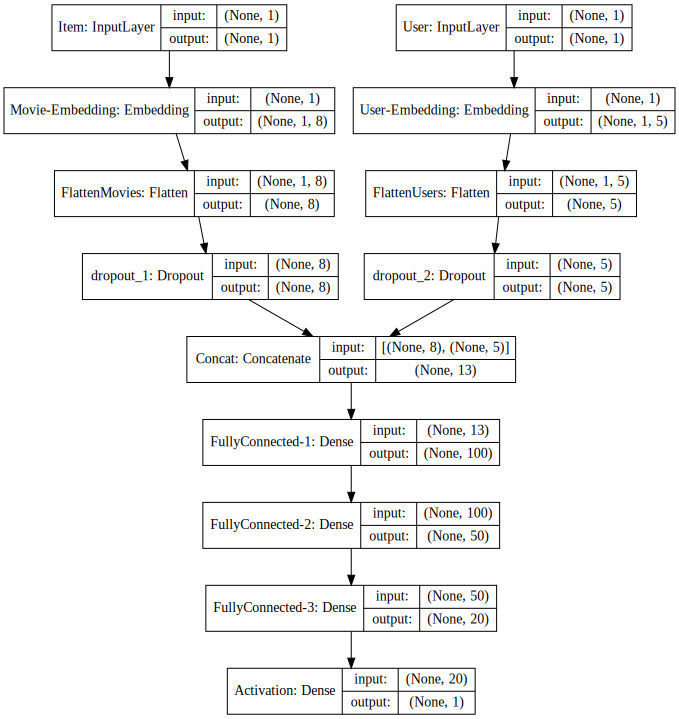

In [24]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [25]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [26]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=10, verbose=1)

Epoch 1/10
80000/80000 [==============================] - 4s 48us/step - loss: 0.8231
Epoch 2/10
80000/80000 [==============================] - 3s 33us/step - loss: 0.7671
Epoch 3/10
80000/80000 [==============================] - 3s 33us/step - loss: 0.7564
Epoch 4/10
80000/80000 [==============================] - 3s 41us/step - loss: 0.7495
Epoch 5/10
80000/80000 [==============================] - 3s 37us/step - loss: 0.7422
Epoch 6/10
80000/80000 [==============================] - 3s 34us/step - loss: 0.7326
Epoch 7/10
80000/80000 [==============================] - 3s 33us/step - loss: 0.7271
Epoch 8/10
80000/80000 [==============================] - 3s 34us/step - loss: 0.7223
Epoch 9/10
80000/80000 [==============================] - 3s 37us/step - loss: 0.7197
Epoch 10/10
80000/80000 [==============================] - 3s 40us/step - loss: 0.7170


In [27]:
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))

0.70775
0.727382292675972


# Method 4 - Using 'Surprise' Package

In [28]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD

# Load the movielens-100k dataset  UserID::MovieID::Rating::Timestamp
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.15)

# trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# we can now query for specific predicions
uid = str(196)  # raw user id
iid = str(302)  # raw item id

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

# run the trained model against the testset
test_pred = algo.test(testset)

# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

# if you wanted to evaluate on the trainset
print("User-based Model : Training Set")
train_pred = algo.test(trainset.build_testset())
accuracy.rmse(train_pred)

user: 196        item: 302        r_ui = 4.00   est = 4.24   {'was_impossible': False}
User-based Model : Test Set
RMSE: 0.9313
User-based Model : Training Set
RMSE: 0.6833


0.6832810310269882

## Benchmark of the various algorithms in Surprise 


In [30]:
'''This module runs a 5-Fold CV for all the algorithms (default parameters) on
the movielens datasets, and reports average RMSE, MAE, and total computation time. '''

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import time
import datetime
import random

import numpy as np
import six
from tabulate import tabulate

from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

# Load the movielens-100k dataset  UserID::MovieID::Rating::Timestamp
data = Dataset.load_builtin('ml-100k')

# The algorithms to cross-validate
classes = (SVD, SVDpp , NMF, SlopeOne, KNNBasic, KNNWithMeans, KNNBaseline, CoClustering, BaselineOnly, NormalPredictor)

np.random.seed(0)
random.seed(0)
kf = KFold(random_state=0)  # folds will be the same for all algorithms.

table = []
for klass in classes:
    start = time.time()
    out = cross_validate(klass(), data, ['rmse', 'mae'], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse']))
    mean_mae = '{:.3f}'.format(np.mean(out['test_mae']))

    new_line = [klass.__name__, mean_rmse, mean_mae, cv_time]
    tabulate([new_line], tablefmt="pipe")  # print current algo perf
    table.append(new_line)

header = ['','RMSE','MAE','Time']
print(tabulate(table, header, tablefmt="pipe"))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity ma

## Gridsearch and Cross validation using 'Surprise'

In [31]:
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [110, 120, 140, 160], 'n_epochs': [90, 100, 110], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


0.9181839273749549
{'n_factors': 140, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9045  0.9101  0.9063  0.9169  0.9108  0.9097  0.0043  
MAE (testset)     0.7142  0.7196  0.7153  0.7254  0.7199  0.7189  0.0040  
Fit time          35.07   37.87   41.20   33.75   34.30   36.44   2.77    
Test time         0.15    0.15    0.13    0.17    0.14    0.15    0.01    


{'fit_time': (35.066062688827515,
  37.871604919433594,
  41.20111799240112,
  33.75367188453674,
  34.304590702056885),
 'test_mae': array([0.71417431, 0.7196305 , 0.71533871, 0.72542388, 0.71990157]),
 'test_rmse': array([0.90447225, 0.91013559, 0.9062653 , 0.91692311, 0.91075403]),
 'test_time': (0.14860200881958008,
  0.15057110786437988,
  0.12892460823059082,
  0.17205476760864258,
  0.13567209243774414)}

# Top N Movies Recommendation

In [32]:
"""
This module illustrates how to retrieve the top-10 items with highest rating
prediction. We first train an SVD algorithm on the MovieLens dataset, and then
predict all the ratings for the pairs (user, item) that are not in the training
set. We then retrieve the top-10 prediction for each user.
"""

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from collections import defaultdict

from surprise import SVD
from surprise import Dataset
import os, io

def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


def read_item_names():
    """Read the u.item file from MovieLens 100-k dataset and returns a
    mapping to convert raw ids into movie names.
    """
    file_name = "ml-100k\\u.item"
    rid_to_name = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
 
    return rid_to_name


# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

''' create a pandas frame from surprise trainset
iterator = trainset.all_ratings()
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1
'''

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=3)

rid_to_name = read_item_names()

for uid, user_ratings in top_n.items():
    print(uid, [rid_to_name[str(int(iid)+1)] for (iid, _) in user_ratings])
    

196 ['Maltese Falcon, The (1941)', 'Spawn (1997)', 'Everyone Says I Love You (1996)']
186 ['Dances with Wolves (1990)', 'Bringing Up Baby (1938)', '3 Ninjas: High Noon At Mega Mountain (1998)']
22 ['Mighty Aphrodite (1995)', 'Everyone Says I Love You (1996)', "What's Eating Gilbert Grape (1993)"]
244 ['Two Bits (1995)', 'Supercop (1992)', 'Three Colors: Blue (1993)']
166 ['Legends of the Fall (1994)', 'Cinema Paradiso (1988)', 'Snow White and the Seven Dwarfs (1937)']
298 ["What's Eating Gilbert Grape (1993)", 'Heat (1995)', 'Jack (1996)']
115 ['Trainspotting (1996)', 'Mr. Smith Goes to Washington (1939)', 'Cinema Paradiso (1988)']
253 ['Die Hard (1988)', 'Brazil (1985)', 'Heat (1995)']
305 ['Night of the Living Dead (1968)', 'D3: The Mighty Ducks (1996)', 'Lost Horizon (1937)']
6 ['It Happened One Night (1934)', 'Apocalypse Now (1979)', 'Amadeus (1984)']
62 ['Aliens (1986)', 'Full Metal Jacket (1987)', 'Cinema Paradiso (1988)']
286 ["Ulee's Gold (1997)", 'Apartment, The (1960)', "What

306 ['Amadeus (1984)', 'Pump Up the Volume (1990)', 'Jack (1996)']
173 ['Snow White and the Seven Dwarfs (1937)', 'It Happened One Night (1934)', 'Graduate, The (1967)']
185 ['Maltese Falcon, The (1941)', 'Jack (1996)', 'Mighty Aphrodite (1995)']
150 ['Clockwork Orange, A (1971)', 'Haunted World of Edward D. Wood Jr., The (1995)', 'Maltese Falcon, The (1941)']
274 ['North by Northwest (1959)', 'Princess Bride, The (1987)', 'Maltese Falcon, The (1941)']
188 ['It Happened One Night (1934)', 'Harold and Maude (1971)', 'Heat (1995)']
48 ['Heavy Metal (1981)', 'Supercop (1992)', 'English Patient, The (1996)']
311 ['Haunted World of Edward D. Wood Jr., The (1995)', 'Annie Hall (1977)', 'It Happened One Night (1934)']
165 ['Haunted World of Edward D. Wood Jr., The (1995)', 'Jack (1996)', 'Deer Hunter, The (1978)']
208 ['Everyone Says I Love You (1996)', 'Spawn (1997)', 'Legends of the Fall (1994)']
2 ['Raiders of the Lost Ark (1981)', 'Princess Bride, The (1987)', 'Cinema Paradiso (1988)']
20